# Part A: IMDb Movie Review Sentiment Analysis

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

## Loading Data

In [7]:
df = pd.read_csv("/kaggle/input/imdb-data-ist-nlp-projecct-part-a/Imdb - data_imdb.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data distribution and and info

In [8]:
df.info()
df['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

- No Null values found
- No class imbalance found

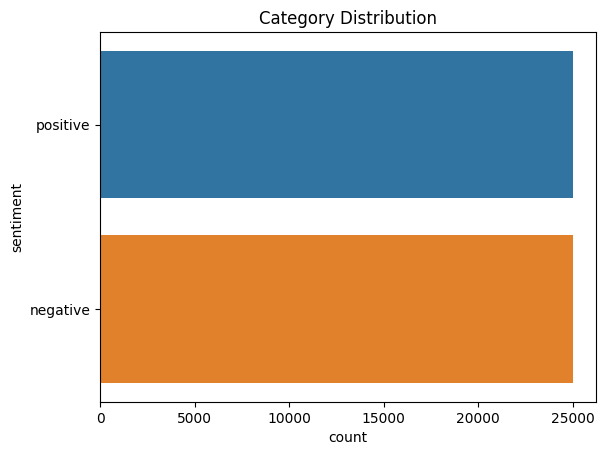

In [9]:
sns.countplot(y=df['sentiment'], order=df['sentiment'].value_counts().index)
plt.title("Category Distribution")
plt.show()

## Text Preprocssing & Cleaning

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?"," ", text)
    text = re.sub(r"[^a-z']", " ", text) 
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)

df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode 'll...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically 's family little boy jake think 's z...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei 's love time money visually stun...


## Feature Engineering

In [11]:
df['word_count'] = df['clean_review'].str.split().str.len()
df['avg_word_length'] = df['clean_review'].apply(
    lambda x: np.mean([len(w) for w in x.split()]) if isinstance(x, str) and x else 0
)
df[['word_count', 'avg_word_length']].describe()


,word_count,avg_word_length
count,50000.000000,50000.000000
mean,127.448180,5.492784
std,96.559111,0.426807
min,1.000000,3.578947
25%,68.000000,5.207547
50%,94.000000,5.480000
75%,155.000000,5.767893
max,1477.000000,13.642857


## Split Dataset into Training-Testing

In [12]:
from sklearn.model_selection import train_test_split

X_text = df['clean_review']
y = df['sentiment'].map({'negative':0, 'positive':1})  # convert to 0/1

X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

## A) TF-IDF Vectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),      
    min_df=5
)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)


## B) Bag-Of-Words Vectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    max_features=10000, 
    ngram_range=(1,2),   # unigrams + bigrams
    min_df=5
)

X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.fit_transform(X_test_text)

## C) Word2Vec 

In [15]:
from gensim.models import Word2Vec

train_sentences = [s.split() for s in X_train_text]

w2v_model = Word2Vec(
    train_sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4
)

def get_w2v(text):
    words = text.split()
    vec_list = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    if len(vec_list) == 0:
        return np.zeros(100)
    return np.mean(vec_list, axis=0)

X_train_w2v = np.vstack([get_w2v(text) for text in X_train_text])
X_test_w2v  = np.vstack([get_w2v(text) for text in X_test_text])


## Comparing Models on all three

# 1. Logistic Regression

## 1.1 TF-IDF

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_tfidf = LogisticRegression(max_iter=2000, n_jobs=-1)

log_reg_tfidf.fit(X_train_tfidf, y_train)
tfidf_preds = log_reg_tfidf.predict(X_test_tfidf)

tfidf_acc = accuracy_score(y_test, tfidf_preds)
tfidf_prec = precision_score(y_test, tfidf_preds)
tfidf_rec = recall_score(y_test, tfidf_preds)
tfidf_f1 = f1_score(y_test, tfidf_preds)

print("TF-IDF : Accuracy :", tfidf_acc)
print("TF-IDF : Precision:", tfidf_prec)
print("TF-IDF : Recall   :", tfidf_rec)
print("TF-IDF : F1-score :", tfidf_f1)


TF-IDF : Accuracy : 0.8954
TF-IDF : Precision: 0.884607975341938
TF-IDF : Recall   : 0.9112919230005954
TF-IDF : F1-score : 0.8977517106549364


## 1.2 Bag-Of-Words

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_bow = LogisticRegression(max_iter=2000, n_jobs=-1)

log_reg_bow.fit(X_train_bow, y_train)
bow_preds = log_reg_bow.predict(X_test_bow)

bow_acc = accuracy_score(y_test, bow_preds)
bow_f1 = f1_score(y_test, bow_preds)
bow_prec = precision_score(y_test, bow_preds)
bow_rec = recall_score(y_test, bow_preds)

print("BoW : Accuracy :", bow_acc)
print("BoW : Precision:", bow_prec)
print("BoW : Recall   :", bow_rec)
print("BoW : F1-score :", bow_f1)

BoW : Accuracy : 0.504
BoW : Precision: 0.5144741663613045
BoW : Recall   : 0.2786267116491367
BoW : F1-score : 0.36148300720906285


## 1.3 Word2Vec

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_w2v = LogisticRegression(max_iter=2000, n_jobs=-1)

log_reg_w2v.fit(X_train_w2v, y_train)
w2v_preds = log_reg_w2v.predict(X_test_w2v)

w2v_acc = accuracy_score(y_test, w2v_preds)
w2v_prec = precision_score(y_test, w2v_preds)
w2v_rec = recall_score(y_test, w2v_preds)
w2v_f1 = f1_score(y_test, w2v_preds)

print("Word2Vec : Accuracy :", w2v_acc)
print("Word2Vec : Precision:", w2v_prec)
print("Word2Vec : Recall   :", w2v_rec)
print("Word2Vec : F1-score :", w2v_f1)

Word2Vec : Accuracy : 0.8566
Word2Vec : Precision: 0.8540561775682577
Word2Vec : Recall   : 0.8628696169874975
Word2Vec : F1-score : 0.8584402764067127


# 2. Naive Bayes

## 2.1 TF-IDF

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nb_tfidf = MultinomialNB()

nb_tfidf.fit(X_train_tfidf, y_train)
nb_tfidf_preds = nb_tfidf.predict(X_test_tfidf)

nb_tfidf_acc = accuracy_score(y_test, nb_tfidf_preds)
nb_tfidf_prec = precision_score(y_test, nb_tfidf_preds)
nb_tfidf_rec = recall_score(y_test, nb_tfidf_preds)
nb_tfidf_f1 = f1_score(y_test, nb_tfidf_preds)

print("Naive Bayes (TF-IDF) : Accuracy :", nb_tfidf_acc)
print("Naive Bayes (TF-IDF) : Precision:", nb_tfidf_prec)
print("Naive Bayes (TF-IDF) : Recall   :", nb_tfidf_rec)
print("Naive Bayes (TF-IDF) : F1-score :", nb_tfidf_f1)

Naive Bayes (TF-IDF) : Accuracy : 0.8653
Naive Bayes (TF-IDF) : Precision: 0.8587252234745434
Naive Bayes (TF-IDF) : Recall   : 0.8769597142290136
Naive Bayes (TF-IDF) : F1-score : 0.8677466863033874


## 2.2 Bag-Of-Words

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nb_bow = MultinomialNB()

nb_bow.fit(X_train_bow, y_train)
nb_bow_preds = nb_bow.predict(X_test_bow)

nb_bow_acc = accuracy_score(y_test, nb_bow_preds)
nb_bow_prec = precision_score(y_test, nb_bow_preds)
nb_bow_rec = recall_score(y_test, nb_bow_preds)
nb_bow_f1 = f1_score(y_test, nb_bow_preds)

print("Naive Bayes (BoW) : Accuracy :", nb_bow_acc)
print("Naive Bayes (BoW) : Precision:", nb_bow_prec)
print("Naive Bayes (BoW) : Recall   :", nb_bow_rec)
print("Naive Bayes (BoW) : F1-score :", nb_bow_f1)

Naive Bayes (BoW) : Accuracy : 0.5654
Naive Bayes (BoW) : Precision: 0.567530695770805
Naive Bayes (BoW) : Recall   : 0.5778924389759873
Naive Bayes (BoW) : F1-score : 0.5726647000983285


# 3. Support Vector Machine (SVM)

## 3.1 TF-IDF

In [21]:
from sklearn.svm import LinearSVC

svm_tfidf = LinearSVC()

svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_preds = svm_tfidf.predict(X_test_tfidf)

svm_tfidf_acc = accuracy_score(y_test, svm_tfidf_preds)
svm_tfidf_prec = precision_score(y_test, svm_tfidf_preds)
svm_tfidf_rec = recall_score(y_test, svm_tfidf_preds)
svm_tfidf_f1 = f1_score(y_test, svm_tfidf_preds)

print("SVM (TF-IDF) : Accuracy :", svm_tfidf_acc)
print("SVM (TF-IDF) : Precision:", svm_tfidf_prec)
print("SVM (TF-IDF) : Recall   :", svm_tfidf_rec)
print("SVM (TF-IDF) : F1-score :", svm_tfidf_f1)


SVM (TF-IDF) : Accuracy : 0.8884
SVM (TF-IDF) : Precision: 0.8827317073170732
SVM (TF-IDF) : Recall   : 0.8977971819805517
SVM (TF-IDF) : F1-score : 0.8902007083825266


## 3.2 Bag-Of-Words

In [22]:
from sklearn.svm import LinearSVC

svm_bow = LinearSVC()

svm_bow.fit(X_train_bow, y_train)
svm_bow_preds = svm_bow.predict(X_test_bow)

svm_bow_acc = accuracy_score(y_test, svm_bow_preds)
svm_bow_prec = precision_score(y_test, svm_bow_preds)
svm_bow_rec = recall_score(y_test, svm_bow_preds)
svm_bow_f1 = f1_score(y_test, svm_bow_preds)

print("SVM (BoW) : Accuracy :", svm_bow_acc)
print("SVM (BoW) : Precision:", svm_bow_prec)
print("SVM (BoW) : Recall   :", svm_bow_rec)
print("SVM (BoW) : F1-score :", svm_bow_f1)


SVM (BoW) : Accuracy : 0.5074
SVM (BoW) : Precision: 0.5151922559827911
SVM (BoW) : Recall   : 0.3802341734471125
SVM (BoW) : F1-score : 0.437542817994976


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 3.3 Word2Vec

In [23]:
from sklearn.svm import LinearSVC
svm_w2v = LinearSVC()

svm_w2v.fit(X_train_w2v, y_train)
svm_w2v_preds = svm_w2v.predict(X_test_w2v)

svm_w2v_acc = accuracy_score(y_test, svm_w2v_preds)
svm_w2v_prec = precision_score(y_test, svm_w2v_preds)
svm_w2v_rec = recall_score(y_test, svm_w2v_preds)
svm_w2v_f1 = f1_score(y_test, svm_w2v_preds)

print("SVM (Word2Vec) : Accuracy :", svm_w2v_acc)
print("SVM (Word2Vec) : Precision:", svm_w2v_prec)
print("SVM (Word2Vec) : Recall   :", svm_w2v_rec)
print("SVM (Word2Vec) : F1-score :", svm_w2v_f1)

SVM (Word2Vec) : Accuracy : 0.8564
SVM (Word2Vec) : Precision: 0.8524750538055175
SVM (Word2Vec) : Recall   : 0.8646556856519151
SVM (Word2Vec) : F1-score : 0.8585221674876847


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# 4. Random Forest

## 4.1 TF-IDF

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_tfidf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

rf_tfidf.fit(X_train_tfidf.toarray(), y_train)
rf_tfidf_preds = rf_tfidf.predict(X_test_tfidf.toarray())

rf_tfidf_acc = accuracy_score(y_test, rf_tfidf_preds)
rf_tfidf_prec = precision_score(y_test, rf_tfidf_preds)
rf_tfidf_rec = recall_score(y_test, rf_tfidf_preds)
rf_tfidf_f1 = f1_score(y_test, rf_tfidf_preds)

print("Random Forest (TF-IDF) : Accuracy :", rf_tfidf_acc)
print("Random Forest (TF-IDF) : Precision:", rf_tfidf_prec)
print("Random Forest (TF-IDF) : Recall   :", rf_tfidf_rec)
print("Random Forest (TF-IDF) : F1-score :", rf_tfidf_f1)

Random Forest (TF-IDF) : Accuracy : 0.8634
Random Forest (TF-IDF) : Precision: 0.8663474965090764
Random Forest (TF-IDF) : Recall   : 0.8618773566183766
Random Forest (TF-IDF) : F1-score : 0.8641066454436928


## 4.2 Bag-Of-Words

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_bow = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

rf_bow.fit(X_train_bow.toarray(), y_train)
rf_bow_preds = rf_bow.predict(X_test_bow.toarray())

rf_bow_acc = accuracy_score(y_test, rf_bow_preds)
rf_bow_prec = precision_score(y_test, rf_bow_preds)
rf_bow_rec = recall_score(y_test, rf_bow_preds)
rf_bow_f1 = f1_score(y_test, rf_bow_preds)

print("Random Forest (BoW) : Accuracy :", rf_bow_acc)
print("Random Forest (BoW) : Precision:", rf_bow_prec)
print("Random Forest (BoW) : Recall   :", rf_bow_rec)
print("Random Forest (BoW) : F1-score :", rf_bow_f1)

Random Forest (BoW) : Accuracy : 0.5324
Random Forest (BoW) : Precision: 0.5346837378176954
Random Forest (BoW) : Recall   : 0.5552689025600318
Random Forest (BoW) : F1-score : 0.5447819314641745


## 4.3 Word2Vec

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_w2v = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

rf_w2v.fit(X_train_w2v, y_train)
rf_w2v_preds = rf_w2v.predict(X_test_w2v)

rf_w2v_acc = accuracy_score(y_test, rf_w2v_preds)
rf_w2v_prec = precision_score(y_test, rf_w2v_preds)
rf_w2v_rec = recall_score(y_test, rf_w2v_preds)
rf_w2v_f1 = f1_score(y_test, rf_w2v_preds)

print("Random Forest (Word2Vec) : Accuracy :", rf_w2v_acc)
print("Random Forest (Word2Vec) : Precision:", rf_w2v_prec)
print("Random Forest (Word2Vec) : Recall   :", rf_w2v_rec)
print("Random Forest (Word2Vec) : F1-score :", rf_w2v_f1)

Random Forest (Word2Vec) : Accuracy : 0.8292
Random Forest (Word2Vec) : Precision: 0.8219601778465108
Random Forest (Word2Vec) : Recall   : 0.843818217900377
Random Forest (Word2Vec) : F1-score : 0.8327457892675284


## Comparison Table

In [27]:
import pandas as pd

results = []

# Logistic Regression
results.append(["LogReg", "BoW",
                accuracy_score(y_test, bow_preds),
                precision_score(y_test, bow_preds, average='weighted'),
                recall_score(y_test, bow_preds, average='weighted'),
                f1_score(y_test, bow_preds, average='weighted')])

results.append(["LogReg", "TF-IDF",
                accuracy_score(y_test, tfidf_preds),
                precision_score(y_test, tfidf_preds, average='weighted'),
                recall_score(y_test, tfidf_preds, average='weighted'),
                f1_score(y_test, tfidf_preds, average='weighted')])

results.append(["LogReg", "Word2Vec",
                accuracy_score(y_test, w2v_preds),
                precision_score(y_test, w2v_preds, average='weighted'),
                recall_score(y_test, w2v_preds, average='weighted'),
                f1_score(y_test, w2v_preds, average='weighted')])

# Naive Bayes
results.append(["Naive Bayes", "BoW",
                accuracy_score(y_test, nb_bow_preds),
                precision_score(y_test, nb_bow_preds, average='weighted'),
                recall_score(y_test, nb_bow_preds, average='weighted'),
                f1_score(y_test, nb_bow_preds, average='weighted')])

results.append(["Naive Bayes", "TF-IDF",
                accuracy_score(y_test, nb_tfidf_preds),
                precision_score(y_test, nb_tfidf_preds, average='weighted'),
                recall_score(y_test, nb_tfidf_preds, average='weighted'),
                f1_score(y_test, nb_tfidf_preds, average='weighted')])

# SVM
results.append(["SVM", "BoW",
                accuracy_score(y_test, svm_bow_preds),
                precision_score(y_test, svm_bow_preds, average='weighted'),
                recall_score(y_test, svm_bow_preds, average='weighted'),
                f1_score(y_test, svm_bow_preds, average='weighted')])

results.append(["SVM", "TF-IDF",
                accuracy_score(y_test, svm_tfidf_preds),
                precision_score(y_test, svm_tfidf_preds, average='weighted'),
                recall_score(y_test, svm_tfidf_preds, average='weighted'),
                f1_score(y_test, svm_tfidf_preds, average='weighted')])

results.append(["SVM", "Word2Vec",
                accuracy_score(y_test, svm_w2v_preds),
                precision_score(y_test, svm_w2v_preds, average='weighted'),
                recall_score(y_test, svm_w2v_preds, average='weighted'),
                f1_score(y_test, svm_w2v_preds, average='weighted')])

comparison_df = pd.DataFrame(
    results,
    columns=["Model", "Features", "Accuracy", "Precision", "Recall", "F1-score"]
)

comparison_df.sort_values("F1-score", ascending=False)


,Model,Features,Accuracy,Precision,Recall,F1-score
1,LogReg,TF-IDF,0.8954,0.895741,0.8954,0.895363
6,SVM,TF-IDF,0.8884,0.888500,0.8884,0.888384
4,Naive Bayes,TF-IDF,0.8653,0.865445,0.8653,0.865273
2,LogReg,Word2Vec,0.8566,0.856627,0.8566,0.856590
7,SVM,Word2Vec,0.8564,0.856458,0.8564,0.856384
3,Naive Bayes,BoW,0.5654,0.565360,0.5654,0.565332
5,SVM,BoW,0.5074,0.509038,0.5074,0.499198
0,LogReg,BoW,0.5040,0.507328,0.5040,0.477086


## Best model

In [28]:
best_row = comparison_df.sort_values("F1-score", ascending=False).iloc[0]
best_row


Model          LogReg
Features       TF-IDF
Accuracy       0.8954
Precision    0.895741
Recall         0.8954
F1-score     0.895363
Name: 1, dtype: object

* Based on comparative evaluation across multiple models and feature representations, Logistic Regression with TF-IDF features achieved the highest F1-score and was selected as the final model for further analysis.

## Deriving Insights

### Top Positive Keywords

In [29]:
import numpy as np

feature_names = tfidf.get_feature_names_out()

coef = log_reg_tfidf.coef_[0]   
top_indices = np.argsort(coef)[-15:][::-1]

top_positive_words = [feature_names[i] for i in top_indices]
top_positive_words

['great',
 'excellent',
 'perfect',
 'wonderful',
 'amazing',
 'brilliant',
 'best',
 'favorite',
 'loved',
 'hilarious',
 'one best',
 'today',
 'fantastic',
 'enjoyed',
 'fun']

### Top Negative Keywords

In [30]:
bottom_indices = np.argsort(coef)[:10]
negative_words = [feature_names[i] for i in bottom_indices]
negative_words


['worst',
 'bad',
 'awful',
 'boring',
 'waste',
 'poor',
 'terrible',
 'nothing',
 'dull',
 'horrible']

## Visualizing

### For Top Positive Keywords

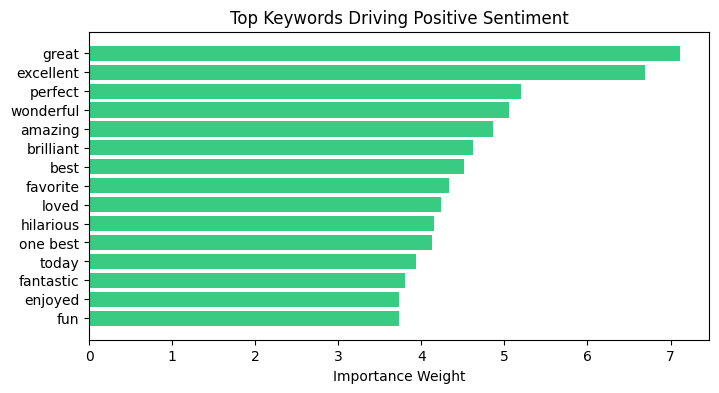

In [31]:
import matplotlib.pyplot as plt

top_scores = coef[top_indices]

plt.figure(figsize=(8,4))
plt.barh(top_positive_words[::-1], top_scores[::-1], color = '#38cb82')
plt.title("Top Keywords Driving Positive Sentiment")
plt.xlabel("Importance Weight")
plt.show()


### For Top Negative Keywords

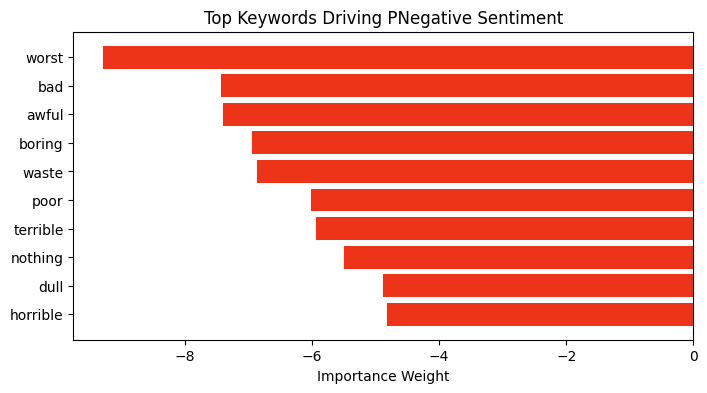

In [32]:
import matplotlib.pyplot as plt

bottom_scores = coef[bottom_indices]

plt.figure(figsize=(8,4))
plt.barh(negative_words[::-1], bottom_scores[::-1],color = '#ed3419')
plt.title("Top Keywords Driving PNegative Sentiment")
plt.xlabel("Importance Weight")
plt.show()


### ROC-AUC

ROC–AUC Score: 0.9629381451567512


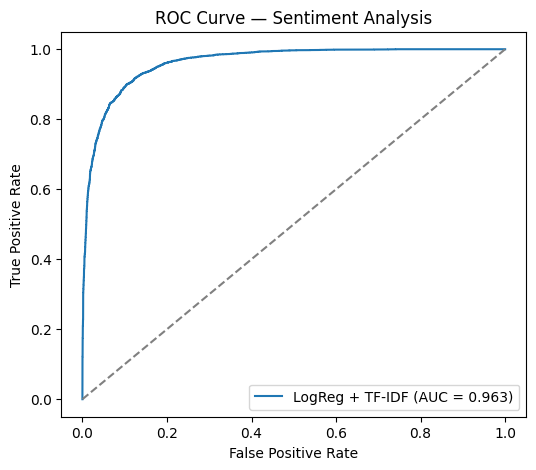

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
# Probability for the positive class
y_test_proba = log_reg_tfidf.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print("ROC–AUC Score:", roc_auc)


import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogReg + TF-IDF (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Sentiment Analysis")
plt.legend()
plt.show()

### Confusion Matrix

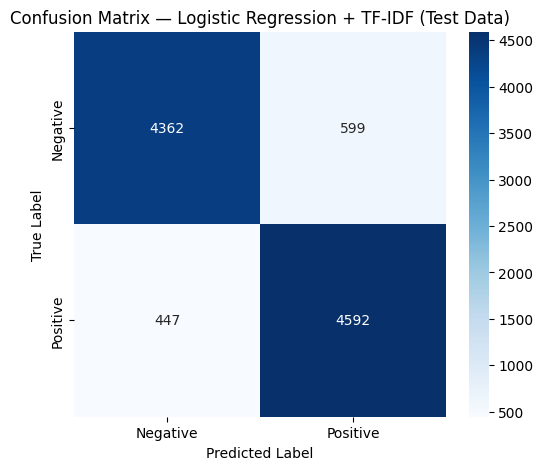

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, tfidf_preds)
cm
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Logistic Regression + TF-IDF (Test Data)")
plt.show()
